# Домашнее задание
## Параллельные вычисления

Тема: "Решение задачи линейного программирования при помощи параллельного варианта симплекс-метода"

Выполнили:
- Зимин Григорий Сергеевич, ИУ8-112
- Александров Алексей Н., ИУ8-114
- Сакулин Даниил Игоревич, ИУ8-115

In [1]:
import logging
from pathlib import Path

import numpy as np
import cupy as cp

from src.simplex.simplex_problem import SimplexProblem, Solution

In [2]:
logging.basicConfig(
    level=logging.CRITICAL, 
    format='%(message)s',
)

In [3]:
sample_input_path = Path("sample_input_LLP.json")
problem = SimplexProblem(sample_input_path)

In [4]:
solution, _ = problem.solve()
solution

([0, 0.17241379310344826, 0.396551724137931, 2.0, 0, 0], 0.9655172413793104)

In [5]:
problem = SimplexProblem(sample_input_path, use_gpu="cupy", verbose=False)

In [6]:
solution, _ = problem.solve(timer=True)
solution

([0, 0.17241379310344826, 0.396551724137931, 2.0, 0, 0], 0.9655172413793104)

### Warming Up!

In [7]:
a_np = np.random.rand(10000, 10000)
b_np = np.random.rand(10000, 10000)

In [8]:
%%time
c = np.dot(a_np, b_np)
c

CPU times: user 2min 28s, sys: 20.1 s, total: 2min 48s
Wall time: 15.1 s


array([[2501.33908218, 2483.41351733, 2484.70357831, ..., 2526.77623697,
        2510.32025862, 2505.42639859],
       [2497.81990191, 2473.80013882, 2482.88272097, ..., 2524.66771293,
        2490.88166288, 2522.52170951],
       [2492.62917437, 2477.61704955, 2485.90239782, ..., 2516.61385568,
        2524.50222687, 2519.15286791],
       ...,
       [2498.51732665, 2485.42013535, 2483.96973668, ..., 2520.76422166,
        2501.79180487, 2507.61090583],
       [2474.11456765, 2459.44969722, 2464.58919488, ..., 2522.05401979,
        2493.95597995, 2500.32008812],
       [2502.53341359, 2497.65017469, 2516.31388142, ..., 2530.9681113 ,
        2525.98322406, 2517.40262668]])

In [9]:
%%time
a_cp = cp.asarray(a_np)
b_cp = cp.asarray(b_np)
c = cp.dot(a_cp, b_cp)
c

CPU times: user 276 ms, sys: 2.26 s, total: 2.54 s
Wall time: 1.88 s


array([[2501.33908218, 2483.41351733, 2484.70357831, ..., 2526.77623697,
        2510.32025862, 2505.42639859],
       [2497.81990191, 2473.80013882, 2482.88272097, ..., 2524.66771293,
        2490.88166288, 2522.52170951],
       [2492.62917437, 2477.61704955, 2485.90239782, ..., 2516.61385568,
        2524.50222687, 2519.15286791],
       ...,
       [2498.51732665, 2485.42013535, 2483.96973668, ..., 2520.76422166,
        2501.79180487, 2507.61090583],
       [2474.11456765, 2459.44969722, 2464.58919488, ..., 2522.05401979,
        2493.95597995, 2500.32008812],
       [2502.53341359, 2497.65017469, 2516.31388142, ..., 2530.9681113 ,
        2525.98322406, 2517.40262668]])

### Проведение бенчмарка

In [10]:
from src.benchmark import benchmark_lp_solver

increase_iter = (2, 5, 10, 20, 40, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500)

report_table = benchmark_lp_solver(problem_size_iterable=increase_iter)
report_table

Processing problem with size: 2
  CPU completed: 0.856 ms
  GPU completed: 3.397 ms
  CPU and GPU have found equivalent solution: f = 1.206
Processing problem with size: 5
  CPU completed: 5.789 ms
  GPU completed: 8.253 ms
  CPU and GPU have found equivalent solution: f = 0.251
Processing problem with size: 10
  CPU completed: 17.385 ms
  GPU completed: 11.574 ms
  CPU and GPU have found equivalent solution: f = 0.239
Processing problem with size: 20
  CPU completed: 75.819 ms
  GPU completed: 22.816 ms
  CPU and GPU have found equivalent solution: f = 0.220
Processing problem with size: 40
  CPU completed: 541.551 ms
  GPU completed: 80.026 ms
  CPU and GPU have found equivalent solution: f = 0.236
Processing problem with size: 80
  CPU completed: 2070.570 ms
  GPU completed: 142.813 ms
  CPU and GPU have found equivalent solution: f = 0.058
Processing problem with size: 100
  CPU completed: 2821.442 ms
  GPU completed: 148.261 ms
  CPU and GPU have found equivalent solution: f = 0.0

Размерность задачи (число переменных / ограничений),CPU Time (ms),GPU Time (ms),Прирост производительности
2,0.856,3.397,0.25
5,5.789,8.253,0.70
10,17.385,11.574,1.50
20,75.819,22.816,3.32
40,541.551,80.026,6.77
80,2070.570,142.813,14.50
100,2821.442,148.261,19.03
150,21212.552,742.497,28.57
200,21121.570,570.949,36.99
250,65149.789,1412.258,46.13


In [11]:
import matplotlib.pyplot as plt

# Извлечение столбцов из таблицы для построения графиков
sizes = [int(row[0]) for row in report_table.rows]
cpu_times = [float(row[1]) for row in report_table.rows]
gpu_times = [float(row[2]) for row in report_table.rows]

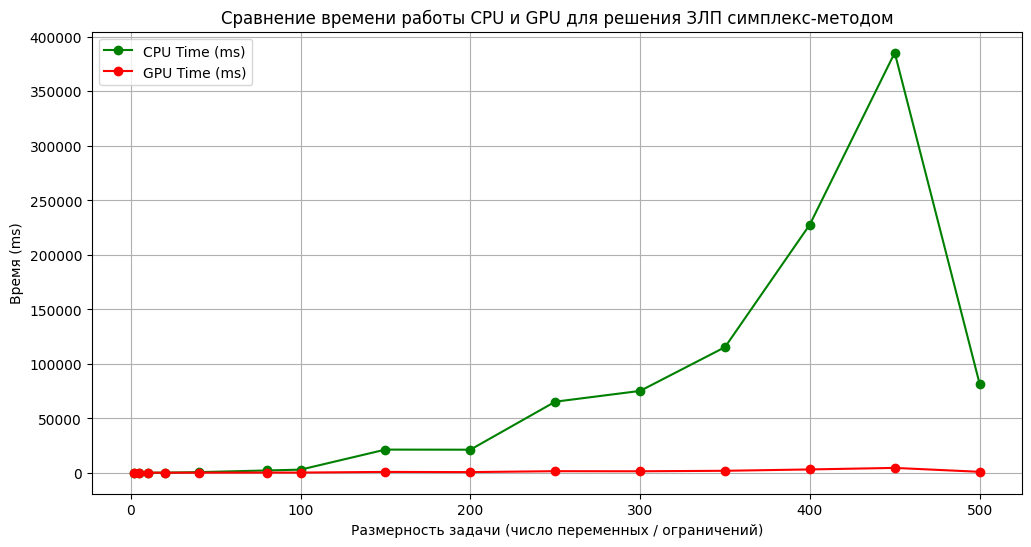

In [12]:
plt.figure(figsize=(12, 6))

# График времени работы CPU
plt.plot(sizes, cpu_times, label='CPU Time (ms)', marker='o', color='green')
# График времени работы GPU
plt.plot(sizes, gpu_times, label='GPU Time (ms)', marker='o', color='red')

plt.xlabel('Размерность задачи (число переменных / ограничений)')
plt.ylabel('Время (ms)')
plt.title('Сравнение времени работы CPU и GPU для решения ЗЛП симплекс-методом')
plt.legend()
plt.grid()
plt.show()

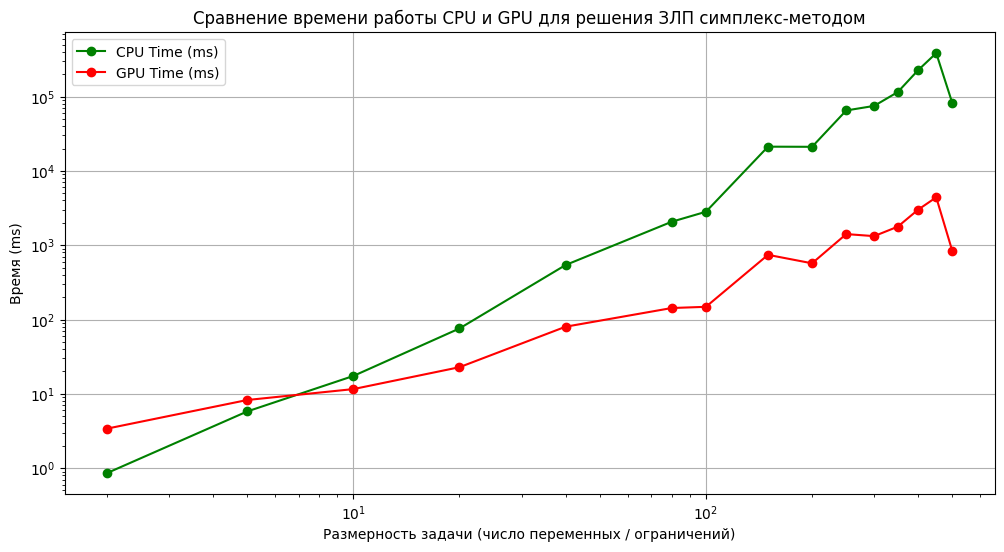

In [13]:
plt.figure(figsize=(12, 6))

# График времени работы CPU
plt.plot(sizes, cpu_times, label='CPU Time (ms)', marker='o', color='green')
# График времени работы GPU
plt.plot(sizes, gpu_times, label='GPU Time (ms)', marker='o', color='red')

plt.xlabel('Размерность задачи (число переменных / ограничений)')
plt.ylabel('Время (ms)')
plt.title('Сравнение времени работы CPU и GPU для решения ЗЛП симплекс-методом')
plt.legend()
plt.grid()
# Логарифмическая шкала для лучшей визуализации
plt.xscale('log')  
plt.yscale('log')
plt.show()